# **Machine Learning using scikit-learn**

As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use IBM's HR Attrition dataset, available here: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset.
The dataset contains data on 1470 employees. The variables covered in this dataset focus heavily on demographic attributes (e.g. gender, age and race), social related attributes (e.g. marital status) and work related attributes (e.g. tenure and pay).

In [43]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PowerTransformer

## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [33]:
employee_df = pd.read_excel('/content/IBM-HR-Data-Employee-Attrition.xlsx')
display(employee_df.head())
employee_df.info()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [34]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Data cleaning and EDA

We can now briefly explore our data. For now, we can observe that there are a zero NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop in case future data sets from IBM HR might have NA values. You are welcome to explore additional aspects of the data and build out 2-3 features on your own

In [35]:
employee_df = employee_df.dropna(subset=['Attrition'])
employee_df.shape
employee_df['Attrition']

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object

In [36]:
employee_df['Attrition'] = employee_df['Attrition'].apply(lambda x: 1 if x == "Yes" else 0)
employee_df['Attrition']

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

In [37]:
employee_df['Over18'] = employee_df['Over18'].apply(lambda x: 1 if x == "Y" else 0)
employee_df['Over18']

0       1
1       1
2       1
3       1
4       1
       ..
1465    1
1466    1
1467    1
1468    1
1469    1
Name: Over18, Length: 1470, dtype: int64

In [38]:
employee_df['OverTime'] = employee_df['OverTime'].apply(lambda x: 1 if x == "Yes" else 0)
employee_df['OverTime']

0       1
1       0
2       1
3       1
4       0
       ..
1465    0
1466    0
1467    1
1468    0
1469    0
Name: OverTime, Length: 1470, dtype: int64

In [39]:
employee_df['Gender'] = employee_df['Gender'].apply(lambda x: 1 if x == "Female" else 0)
employee_df['Gender']

0       1
1       0
2       0
3       1
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Gender, Length: 1470, dtype: int64

In [40]:
class_column = 'Attrition'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(employee_df.drop(columns=class_column), employee_df[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=employee_df[class_column])

Quick sanity check to make sure that everything seems correct:

In [41]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1102, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1331,48,Travel_Rarely,1224,Research & Development,10,3,Life Sciences,1,1867,4,...,4,80,0,29,3,3,22,10,12,9
485,27,Travel_Rarely,798,Research & Development,6,4,Medical,1,655,1,...,3,80,2,6,5,2,5,3,0,3
1368,34,Travel_Frequently,735,Research & Development,22,4,Other,1,1932,3,...,2,80,0,16,3,3,15,10,6,11
579,34,Travel_Rarely,121,Research & Development,2,4,Medical,1,804,3,...,3,80,0,6,3,3,6,5,1,3
142,38,Travel_Rarely,364,Research & Development,3,5,Technical Degree,1,193,4,...,2,80,0,19,2,3,3,2,2,2



On X test: 
X test dimensions:  (368, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
129,49,Travel_Rarely,470,Research & Development,20,4,Medical,1,170,3,...,3,80,0,16,2,2,15,11,5,11
1120,38,Travel_Rarely,437,Sales,16,3,Life Sciences,1,1583,2,...,2,80,0,8,5,4,3,2,1,2
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
965,25,Travel_Rarely,882,Research & Development,19,1,Medical,1,1358,4,...,3,80,3,7,6,2,3,2,1,2
94,32,Travel_Rarely,1093,Sales,6,4,Medical,1,125,2,...,1,80,0,12,0,3,11,8,5,7


In [42]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1102,)


1331    0
485     0
1368    0
579     0
142     0
Name: Attrition, dtype: int64


On y test: 
y test dimensions:  (368,)


129     0
1120    0
3       0
965     0
94      0
Name: Attrition, dtype: int64

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [ ]:
# TODO: establish your own pipelines for the different data types

cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder())])

num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])

In [ ]:
employee_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [ ]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   int64 
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
# TODO: establish your preprocessing pipeline by your feature set

cat_cols = ['MaritalStatus', 'JobRole', 'EducationField', 'Department', 'BusinessTravel']
num_cols = ['Age',  'DailyRate',
       'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

preproc = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols),
                             ('num_pipe', num_pipeline, num_cols)],
                             remainder='passthrough')


In [ ]:
# TODO: set up your modeling pipeline


logisticRegressionPipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

randomForestClassifierPipe = Pipeline(steps=[('preproc', preproc),('mdl', RandomForestClassifier())])

XGBClassifierPipe = Pipeline(steps=[('preproc', preproc),('mdl', xgb.XGBClassifier())])


# visualization of the pipeline
with config_context(display='diagram'):
    display(logisticRegressionPipe)
    display(randomForestClassifierPipe)
    display(XGBClassifierPipe)


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['MaritalStatus', 'JobRole',
                                                   'EducationField',
                                                   'Department',
                                                   'BusinessTravel']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   Sta...
                                                   'NumCompaniesWorked',
                                                   'Over18', 'OverTime',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StandardHours',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['MaritalStatus', 'JobRole',
                                                   'EducationField',
                                                   'Department',
                                                   'BusinessTravel']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   Sta...
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'Over18', 'OverTime',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StandardHours',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('mdl', RandomForestClassifier())])

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['MaritalStatus', 'JobRole',
                                                   'EducationField',
                                                   'Department',
                                                   'BusinessTravel']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   Sta...
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'Over18', 'OverTime',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StandardHours',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('mdl', XGBClassifier())])

##Logistic Regression 
## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [ ]:

# TODO: set up your tuning grid 

tuning_grid1 = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }

grid_search1 = GridSearchCV(logisticRegressionPipe, param_grid = tuning_grid1, cv = 5, return_train_score=True)

# TODO: fit your model

grid_search1.fit(X_train, y_train.values.ravel())

# TODO: find the best performing model parameters and their values

print(grid_search1.best_score_)
grid_search1.best_params_



0.879325380501851


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}

##Random Forest
## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [ ]:
randomForestClassifierPipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preproc', 'mdl', 'preproc__n_jobs', 'preproc__remainder', 'preproc__sparse_threshold', 'preproc__transformer_weights', 'preproc__transformers', 'preproc__verbose', 'preproc__verbose_feature_names_out', 'preproc__cat_pipe', 'preproc__num_pipe', 'preproc__cat_pipe__memory', 'preproc__cat_pipe__steps', 'preproc__cat_pipe__verbose', 'preproc__cat_pipe__cat_impute', 'preproc__cat_pipe__onehot_cat', 'preproc__cat_pipe__cat_impute__add_indicator', 'preproc__cat_pipe__cat_impute__copy', 'preproc__cat_pipe__cat_impute__fill_value', 'preproc__cat_pipe__cat_impute__missing_values', 'preproc__cat_pipe__cat_impute__strategy', 'preproc__cat_pipe__cat_impute__verbose', 'preproc__cat_pipe__onehot_cat__categories', 'preproc__cat_pipe__onehot_cat__drop', 'preproc__cat_pipe__onehot_cat__dtype', 'preproc__cat_pipe__onehot_cat__handle_unknown', 'preproc__cat_pipe__onehot_cat__sparse', 'preproc__num_pipe__memory', 'preproc__num_pipe__steps', 'preproc__num_pipe__verb

In [ ]:

# TODO: set up your tuning grid 

param_grid = { 
    'mdl__n_estimators': [200, 500],
    'mdl__max_features': ['auto', 'sqrt', 'log2'],
    'mdl__max_depth' : [4,5,6,7,8],
    'mdl__criterion' :['gini', 'entropy']
}

tuning_grid3 = GridSearchCV(estimator=randomForestClassifierPipe, param_grid=param_grid, cv= 5)

# TODO: fit your model

tuning_grid3.fit(X_train, y_train.values.ravel())

# TODO: find the best performing model parameters and their values

print(tuning_grid3.best_score_)
tuning_grid3.best_params_



0.8584450843274374


{'mdl__criterion': 'gini',
 'mdl__max_depth': 8,
 'mdl__max_features': 'sqrt',
 'mdl__n_estimators': 200}

##XGBoost
## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [30]:

# TODO: set up your tuning grid 

tuning_grid2 = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }

tuning_grid2 = GridSearchCV(XGBClassifierPipe, param_grid = tuning_grid2, cv = 5, return_train_score=True)

# TODO: fit your model

tuning_grid2.fit(X_train, y_train.values.ravel())

# TODO: find the best performing model parameters and their values

print(tuning_grid2.best_score_)
tuning_grid2.best_params_



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encounte

0.8584368572603868


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}

## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

## Best estimator was the logisistic regression.

In [31]:
# TODO: print your best estimator (pipeline)
print(logisticRegressionPipe)
print(grid_search1.best_score_)
grid_search1.best_params_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['MaritalStatus', 'JobRole',
                                                   'EducationField',
                                                   'Department',
                                                   'BusinessTravel']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                 

{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}

## Variable importance/Performance metrics on test data


Now we assess the importance in the selected model to reveal any potential insights.

Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.



##Logistic Regression

target classes:  [0 1]
vip:  [-3.29752858e-01 -3.06499310e-01  3.42230067e-01 -2.58491830e-01
  5.33375465e-02  3.76721832e-01 -3.86501482e-02 -1.98818790e-01
 -1.62000427e-01 -2.38974606e-01 -3.13081783e-02  2.04162500e-01
  8.24032244e-02 -2.83383528e-01  4.97192007e-02 -1.79629099e-01
 -2.37561513e-01  2.74429614e-01  4.16550190e-04 -3.67117773e-01
  7.26791212e-02 -5.27249469e-01  3.83043218e-01 -1.49815850e-01
 -2.78939719e-01 -1.60351211e-01  3.03478991e-01  6.57330746e-03
  0.00000000e+00 -5.29924094e-02 -3.25409185e-01 -1.80684184e-01
  1.15368115e-02 -3.11734161e-01 -2.82130166e-01 -3.55835567e-01
 -1.67529274e-01 -1.35641200e-02  3.46932306e-01  0.00000000e+00
  7.71745550e-01 -4.20045978e-02 -4.37034683e-02 -2.14060882e-01
  0.00000000e+00 -1.58062282e-01 -1.13367722e-01 -2.01324933e-01
 -2.88595667e-01  2.92482647e-01 -3.87682458e-01  5.09651310e-01
 -4.88417968e-01]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


classification report:                precision    recall  f1-score   support

           0       0.91      0.98      0.94       309
           1       0.80      0.47      0.60        59

    accuracy                           0.90       368
   macro avg       0.85      0.73      0.77       368
weighted avg       0.89      0.90      0.89       368



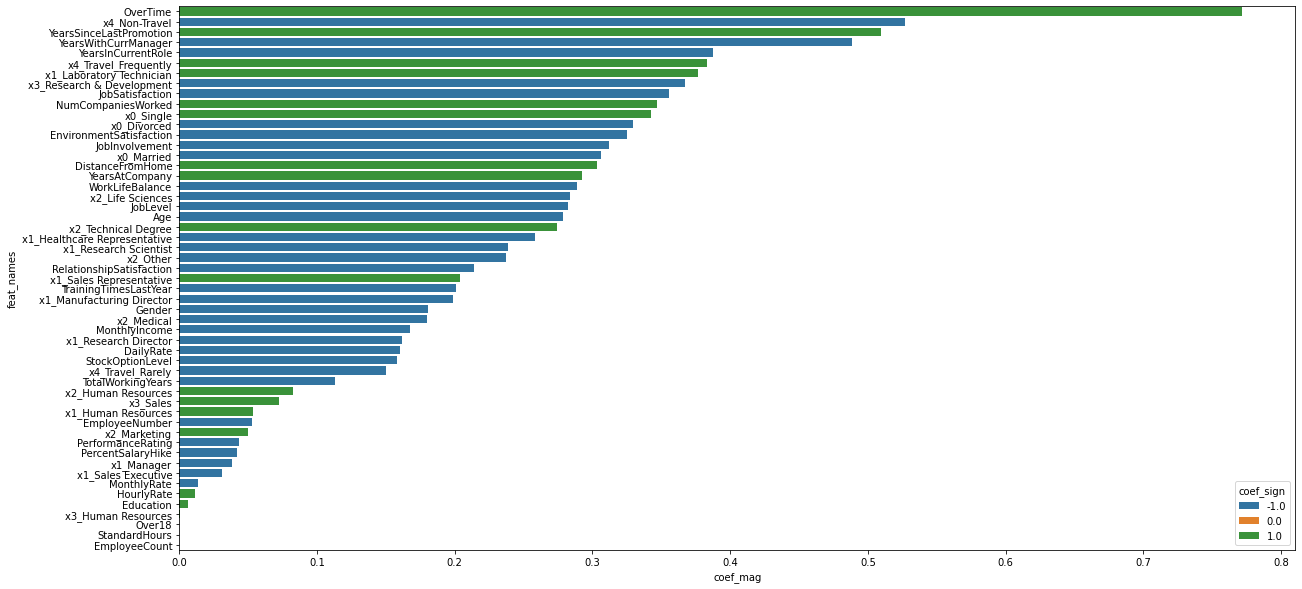

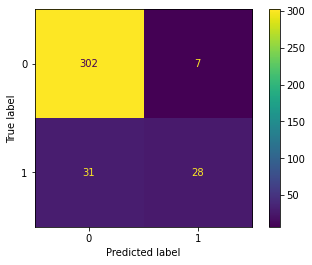

In [ ]:
# TODO: feel free to print out the target classes
print("target classes: ", grid_search1.classes_)

# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip = grid_search1.best_estimator_['mdl'].coef_[0]
print("vip: ", vip)

# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important? It didnt surpise me too much, I thought distance from home would be a little more important than it was.

# #get names in correct preproc order
cat_names = grid_search1.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = grid_search1.best_estimator_.named_steps['preproc'].transformers_[1][2]

# #create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

# TODO: print your classification report of your model

print("classification report: ", classification_report(y_test, grid_search1.best_estimator_.predict(X_test)))

# TODO: plot the confusion matrix graph
cm = confusion_matrix(y_test, grid_search1.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search1.classes_)
disp.plot()

plt.show()


In [ ]:
value = (120000 * 28 * 0.2 - 2000 * 28) - (2000 * 7 - 120000 * 31)
print("value = $", value)

value = $ 4322000.0


##Random Forest Classifier 

target classes:  [0 1]
vip:  RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=200)
classification report:                precision    recall  f1-score   support

           0       0.86      0.98      0.92       309
           1       0.67      0.17      0.27        59

    accuracy                           0.85       368
   macro avg       0.76      0.58      0.59       368
weighted avg       0.83      0.85      0.81       368



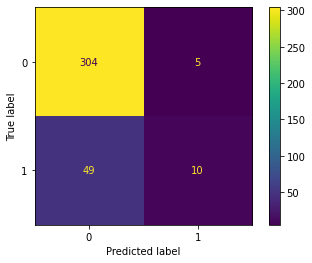

In [ ]:
# TODO: feel free to print out the target classes
print("target classes: ", tuning_grid3.classes_)

# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip = tuning_grid3.best_estimator_['mdl']
print("vip: ", vip)

# TODO: print your classification report of your model

print("classification report: ", classification_report(y_test, tuning_grid3.best_estimator_.predict(X_test)))

# TODO: plot the confusion matrix graph
cm = confusion_matrix(y_test, tuning_grid3.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=tuning_grid3.classes_)
disp.plot()

plt.show()



In [ ]:
value = (120000 * 10 * 0.2 - 2000 * 10) - (2000 * 5 - 120000 * 49)
print("value = $", value)

value = $ 6090000.0


## XGBoost

target classes:  [0 1]
vip:  XGBClassifier(C=0.1, l1_ratio=0.0)
classification report:                precision    recall  f1-score   support

           0       0.88      0.96      0.92       309
           1       0.62      0.34      0.44        59

    accuracy                           0.86       368
   macro avg       0.75      0.65      0.68       368
weighted avg       0.84      0.86      0.84       368



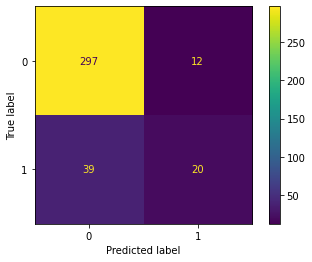

In [ ]:
# TODO: feel free to print out the target classes
print("target classes: ", tuning_grid2.classes_)

# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip = tuning_grid2.best_estimator_['mdl']
print("vip: ", vip)


# TODO: print your classification report of your model

print("classification report: ", classification_report(y_test, tuning_grid2.best_estimator_.predict(X_test)))

# TODO: plot the confusion matrix graph
cm = confusion_matrix(y_test, tuning_grid2.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=tuning_grid2.classes_)
disp.plot()

plt.show()



In [ ]:
value = (120000 * 20 * 0.2 - 2000 * 20) - (2000 * 12 - 120000 * 39)
print("value = $", value)

value = $ 5096000.0


##Best model according to value metric: Random Forest Classifer with a predicted value of $6,090,000.0.

##Feature Engineering

### Feauture #1: PowerTransfomer() on numeric colunms 

In [44]:
num_pipelineFeature1 = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', PowerTransformer())])

In [46]:
preprocFeature1 = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols),
                             ('num_pipe', num_pipelineFeature1, num_cols)],
                             remainder='passthrough')

In [47]:

randomForestClassifierPipeFeature1 = Pipeline(steps=[('preproc', preprocFeature1),('mdl', RandomForestClassifier())])



# visualization of the pipeline
with config_context(display='diagram'):
    display(randomForestClassifierPipeFeature1)


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['MaritalStatus', 'JobRole',
                                                   'EducationField',
                                                   'Department',
                                                   'BusinessTravel']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   Pow...
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'Over18', 'OverTime',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StandardHours',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('mdl', RandomForestClassifier())])

In [48]:

# TODO: set up your tuning grid 

param_gridFeautre1 = { 
    'mdl__n_estimators': [200, 500],
    'mdl__max_features': ['auto', 'sqrt', 'log2'],
    'mdl__max_depth' : [4,5,6,7,8],
    'mdl__criterion' :['gini', 'entropy']
}

tuning_grid3Feautre1 = GridSearchCV(estimator=randomForestClassifierPipeFeature1, param_grid=param_gridFeautre1, cv= 5)

# TODO: fit your model

tuning_grid3Feautre1.fit(X_train, y_train.values.ravel())

# TODO: find the best performing model parameters and their values

print(tuning_grid3Feautre1.best_score_)
tuning_grid3Feautre1.best_params_



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encounte

0.8575401069518718


{'mdl__criterion': 'entropy',
 'mdl__max_depth': 8,
 'mdl__max_features': 'sqrt',
 'mdl__n_estimators': 200}

target classes:  [0 1]
vip:  RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=200)
classification report:                precision    recall  f1-score   support

           0       0.86      1.00      0.92       309
           1       0.90      0.15      0.26        59

    accuracy                           0.86       368
   macro avg       0.88      0.57      0.59       368
weighted avg       0.87      0.86      0.82       368



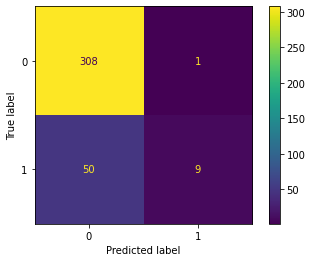

In [49]:
# TODO: feel free to print out the target classes
print("target classes: ", tuning_grid3Feautre1.classes_)

# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip = tuning_grid3Feautre1.best_estimator_['mdl']
print("vip: ", vip)

# TODO: print your classification report of your model

print("classification report: ", classification_report(y_test, tuning_grid3Feautre1.best_estimator_.predict(X_test)))

# TODO: plot the confusion matrix graph
cm = confusion_matrix(y_test, tuning_grid3Feautre1.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=tuning_grid3Feautre1.classes_)
disp.plot()

plt.show()



In [50]:
value = (120000 * 9 * 0.2 - 2000 * 9) - (2000 * 1 - 120000 * 50)
print("value = $", value)

value = $ 6196000.0


In [51]:
print(6196000.0 - 6090000.0)

106000.0


##Performace Value after Feature 1: $6,196,000.00
After the addition of Feature 1 my model increased by 106,000.00 in value.